In [1]:
import numpy as np
import time
from datetime import datetime
import copy
from tqdm import tqdm
import os
import matplotlib as mpl
from matplotlib import pyplot as plt

import importlib, FeatSubLib, dataset_ffcv_torch
importlib.reload(FeatSubLib)
importlib.reload(dataset_ffcv_torch)
from FeatSubLib import FeatureNet, CustomCallback, CustomMultiReadoutCallback, CustomModel, CustomMultiReadoutModel, time_diff
import dataset_ffcv_torch as ds

from collections import OrderedDict

import torch
from torch.optim import SGD, Adam, lr_scheduler
device = 'cuda'

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta
tz = pytz.timezone('US/Eastern')

def time_now():
    return datetime.now(tz)

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [2]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
linestyles = ['--', ':', '-.']
markerstyles = ['.','*','x']

In [3]:
#Width and height of axes.
w=3
h=3
plt.rcParams.update({'font.size': 12, 'figure.figsize': [w,h]})

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = 'small'

#Helper Function for setting figure size by axis size.
#set_size(w,h,ax)
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [4]:
dataset_name = 'cifar10'

In [3]:
hidden_width_list = [1000, 1000, 1000]
## Experiment Parameters
EPOCHS = 2000
opt_name, lr = 'adam', .001

In [4]:
train_size = 50000
x_train, y_train, x_test, y_test, input_dim, num_classes = ds.create_sorted_dataset(train_size, dataset_name, to_onehot=True, flatten=True)
train_loader = [(x_train, y_train)]
test_loader = [(x_test, y_test)]

Files already downloaded and verified
Files already downloaded and verified


In [38]:
x_train.shape

torch.Size([50000, 3072])

In [5]:
base_model = FeatureNet(input_dim, num_classes, hidden_width_list, ntk=True).cuda()
# Compile the model
opt = Adam(base_model.parameters(), lr=lr)
# Scheduler = lr_scheduler.ReduceLROnPlateau(opt)
scheduler = None
loss_fn = lambda y_pred, y: (torch.sum((y_pred - y)**2))/2 #+ lam*torch.sum(torch.abs(features))
callback = CustomCallback(num_classes)
teacher_model = CustomModel(base_model)
teacher_model.compile(opt, loss_fn, callback, scheduler)
teacher_model.fit(train_loader, test_loader, EPOCHS)

Training Started... Wed May 24 12:27:33 2023
Epoch: 2000 | Loss -- Tr: 7536.324 | Tr/Test Acc: 89.8, 53.9 | Tr/Test Loss: 7536.324, 3495.032 | dt: 0h 5m 2s -------
 Training finished! Total time: 0h 5m 2s


Text(0.5, 1.0, 'Accuracy')

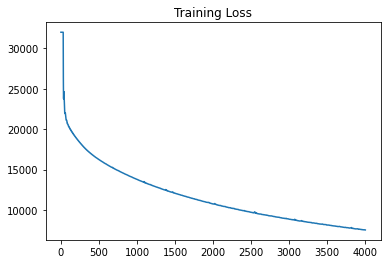

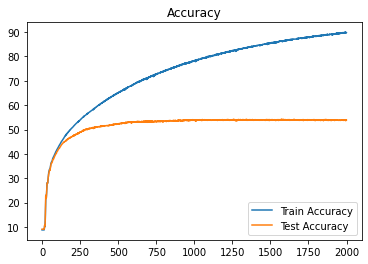

In [6]:
history = callback.get_history()

fig, ax = plt.subplots()
ax.plot(history[0])
ax.set_title('Training Loss')

fig, ax = plt.subplots()
ax.plot(history[1], label = 'Train Accuracy')
ax.plot(history[2], label = 'Test Accuracy')
ax.legend(loc = 'lower right')
ax.set_title('Accuracy')

In [11]:
shifts = np.array([0])

In [12]:
#Log the sparsity of the features as a function of shift at each P value.
base_feature_map = teacher_model.model.feature_map
sparsityFractions = np.empty(shifts.shape[0])
sparsityVariances = np.empty(shifts.shape[0])
features = base_feature_map(x_train).detach().cpu().numpy()
for shiftInd, shift in enumerate(shifts):
    curSparsities = np.sum((features+shift)>0, axis=1)/features.shape[1]
    sparsityFractions[shiftInd]=np.mean(curSparsities)
    sparsityVariances[shiftInd]=np.std(curSparsities)

In [13]:
if len(shifts)<1:
    fig, ax = plt.subplots()
    ax.plot(shifts, sparsityFractions)
    ax.set_xlim([shifts[0], shifts[-1]])
    ax.set_xlabel('Shift', fontsize=20)
    ax.set_ylabel('Sparsity Fraction', fontsize=20)
    ax.set_ylim([0,1])
else:
    print(sparsityFractions)

[0.58558438]


## Get eigenspectrum of larned features

In [14]:
features.shape

(50000, 1000)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define power law function
def power_law(x, a, b):
    return a*np.power(x, b)

def process_matrix(matrix):
    # Center the matrix
    matrix_centered = matrix - np.mean(matrix, axis=0)

    # Compute the empirical covariance matrix
    cov_matrix = np.cov(matrix_centered, rowvar=False)

    # Compute the eigenvalues of the covariance matrix
    eigenvalues, _ = np.linalg.eig(cov_matrix)

    # Sort eigenvalues in decreasing order
    eigenvalues = np.sort(eigenvalues)[::-1]

    # Fit to a power law
    xdata = np.arange(len(eigenvalues)) + 1
    params, _ = curve_fit(power_law, xdata, eigenvalues, p0=(1, -1))

    # Plot singular values and fitted power law
    fig, ax = plt.subplots()
    ax.loglog(eigenvalues, 'b-', label='Eigenvalues')
    ax.loglog(xdata, power_law(xdata, *params), 'r-', label=f'fitted power law: y={params[0]:.2f}x^{params[1]:.2f}')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Eigenvalue')
    ax.set_title('Eigenvalues and fitted power law')
    set_size(3,3)
    ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
    fig = plt.gcf()
    plt.savefig('Cifar10FeaturesEigenSpectrum.png', dpi = 300, bbox_inches = 'tight')

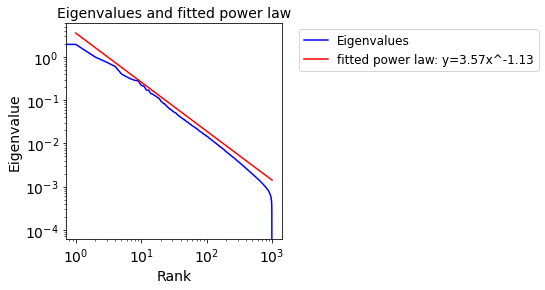

In [36]:
process_matrix(features)

# General Function for Experiment

In [11]:
def runExpt(base_feature_map, dataset, projType, learningRule, ConnDist, OutStrategy, num_samples_list, KVals, shifts, x_train, y_train, x_test, y_test, num_trials = 10, shuffle_degrees = True, stdFrac = 1/2):
    
    dataPath = dataset+'_'+projType+'_'+learningRule+'_'+ConnDist+'Conn_'+OutStrategy+'_data/'
    print(dataPath)
    if not os.path.exists(dataPath):
        # Create a new directory because it does not exist 
        os.makedirs(dataPath)
        print("The new data directory is created!")
    
    numShifts = len(shifts)
    numKVals = len(KVals)
    numPVals = len(num_samples_list)
    
    loss_fn = lambda y_pred, y: (torch.sum((y_pred - y)**2))/2
    scheduler = None
    
    tr_loss = np.empty([numPVals, numKVals, numShifts, num_trials])
    test_loss = np.empty([numPVals, numKVals, numShifts, num_trials])
    tr_acc = np.empty([numPVals, numKVals, numShifts, num_trials])
    test_acc = np.empty([numPVals, numKVals,numShifts, num_trials])
    tr_err = np.empty([numPVals, numKVals,numShifts, num_trials])
    test_err = np.empty([numPVals, numKVals,numShifts, num_trials])

    for PInd,P in enumerate(num_samples_list):
        for KInd, K in enumerate(KVals):
            for shiftInd, shift in enumerate(shifts):  
                start_time = datetime.now(tz)
                #Note: stdFrac is only used when ConnDist is gauss or gamma.
                proj_ratios = FeatSubLib.genAlphas(K, ConnDist, stdFrac)
                for trial in range(num_trials):
                    indices = np.random.permutation(train_size)[:int(P)]
                    train_loader = [(x_train[indices,:], y_train[indices,:])]
                    if shuffle_degrees:
                        proj_ratios = FeatSubLib.genAlphas(K, ConnDist)
                    student = FeatSubLib.StudentNetwork(base_feature_map, num_classes, proj_ratios, shift=shift, OutStrategy = OutStrategy)
                    opt = Adam(student.parameters(), lr=lr)

                    callback = CustomMultiReadoutCallback(num_classes, verbose = False)
                    student_model = CustomMultiReadoutModel(student)
                    student_model.compile(opt, loss_fn, callback, scheduler)
                    #student_model.fit(train_loader, test_loader, EPOCHS)
                    
                    if learningRule == 'lr':
                        student_model.regress_readout(train_loader, test_loader)
                    elif learningRule == 'hebb':
                        student_model.hebbCenter_readout(train_loader, test_loader)
                    else:
                        raise Exception('Learning rule must be lr or hebb')

                    tr_loss[PInd, KInd, shiftInd, trial]=callback.losses[-1]
                    test_loss[PInd, KInd, shiftInd, trial]=callback.test_losses[-1]
                    tr_acc[PInd, KInd, shiftInd, trial]=callback.tr_acc[-1]
                    test_acc[PInd, KInd, shiftInd, trial]=callback.test_acc[-1]
                    tr_err[PInd, KInd, shiftInd, trial]=callback.tr_err[-1]
                    test_err[PInd, KInd, shiftInd, trial]=callback.test_err[-1]
                print('P ='+str(P)+ '; K = ' + str(K) + '; alpha = ' + str(proj_ratios) + '; shift = ' + str(shift) + '; time: ' + str(time_diff(start_time, datetime.now(tz))))
    
    np.save(dataPath+'num_samples_list', num_samples_list)
    np.save(dataPath+'K_list', KVals)
    np.save(dataPath+'shift_list', shifts)
    np.save(dataPath+'sparsity_fracs', sparsityFractions)
    np.save(dataPath+'sparsity_vars', sparsityVariances)   
    torch.save(tr_loss, dataPath+'tr_loss.pt')
    torch.save(test_loss, dataPath+'test_loss.pt')
    torch.save(tr_acc, dataPath+'tr_acc.pt')
    torch.save(test_acc, dataPath+'test_acc.pt')
    torch.save(tr_err, dataPath+'tr_err.pt')
    torch.save(test_err, dataPath+'test_err.pt') 

## Experimental Parameters

In [13]:
num_trials = 5
KVals = np.array([1,4,7,10])
num_samples_list = np.round(np.logspace(2, np.log10(10000), 40))
shifts = np.array([0])
num_trials = 20

In [24]:
importlib.reload(FeatSubLib)
from FeatSubLib import FeatureNet, CustomCallback, CustomMultiReadoutCallback, CustomModel, CustomMultiReadoutModel, time_diff

## Run experiment

In [25]:
runExpt(base_feature_map, 'cifar10', 'np', 'lr', 'gamma', 'threshmean', num_samples_list, KVals, shifts, x_train, y_train, x_test, y_test, num_trials)

cifar10_np_lr_gammaConn_threshmean_data/
P =100.0; K = 1; alpha = [1.]; shift = 0; time: 0h 0m 0s
P =100.0; K = 4; alpha = [0.25015834 0.12171269 0.49156098 0.13656799]; shift = 0; time: 0h 0m 0s
P =100.0; K = 7; alpha = [0.19809946 0.12274776 0.13944533 0.11043471 0.13384588 0.06809258
 0.22733429]; shift = 0; time: 0h 0m 1s
P =100.0; K = 10; alpha = [0.02969285 0.13175152 0.12870797 0.13056628 0.09301124 0.05368281
 0.11328767 0.03737604 0.25301753 0.0289061 ]; shift = 0; time: 0h 0m 1s
P =113.0; K = 1; alpha = [1.]; shift = 0; time: 0h 0m 0s
P =113.0; K = 4; alpha = [0.06648827 0.361731   0.23098003 0.3408007 ]; shift = 0; time: 0h 0m 1s
P =113.0; K = 7; alpha = [0.19593534 0.04754292 0.13871404 0.08529388 0.13850286 0.10394416
 0.2900668 ]; shift = 0; time: 0h 0m 1s
P =113.0; K = 10; alpha = [0.09278428 0.14183587 0.10396337 0.11531121 0.02916053 0.16966568
 0.15708955 0.07775935 0.025894   0.08653614]; shift = 0; time: 0h 0m 1s
P =127.0; K = 1; alpha = [1.]; shift = 0; time: 0h 0m